In [42]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt 
%matplotlib inline

In [43]:
img = cv2.imread("./test/messi2.jpeg")
img.shape

(275, 183, 3)

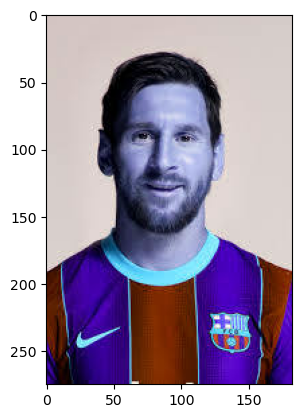

In [44]:
plt.imshow(img)

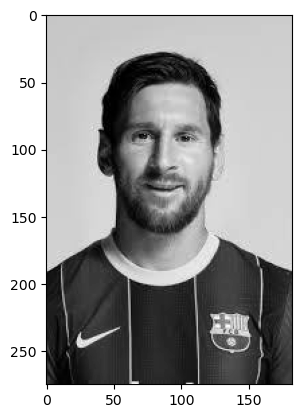

In [45]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

In [46]:
face_cascade = cv2.CascadeClassifier(".\opencv\haarcascades\haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(".\opencv\haarcascades\haarcascade_eye.xml")

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[43, 54, 91, 91]])

In [47]:
(x,y,w,h)=faces[0]


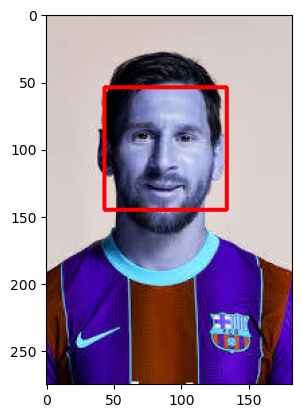

In [48]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

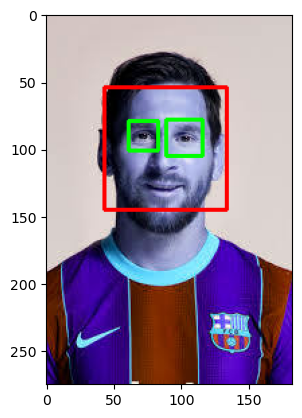

In [49]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()


In [50]:
def get_cropped_image_if_2_eyes(image_path):
    face_cascade = cv2.CascadeClassifier(".\opencv\haarcascades\haarcascade_frontalface_default.xml")
    eye_cascade = cv2.CascadeClassifier(".\opencv\haarcascades\haarcascade_eye.xml")    
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,1.3,5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes)>=2:
            return(roi_color)

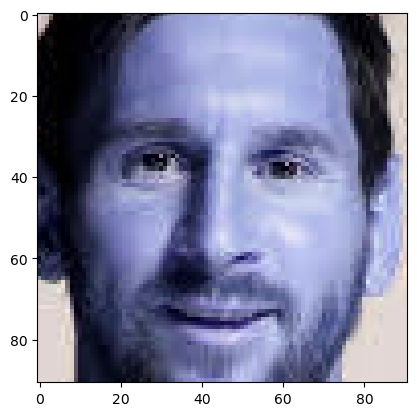

In [51]:
cropped_image = get_cropped_image_if_2_eyes("./test/messi2.jpeg")
plt.imshow(cropped_image)

In [52]:
cropped_image2 = get_cropped_image_if_2_eyes("./test/messi.jpg")
cropped_image2

In [53]:
path_to_data = r".\Data"
path_to_cr_data = r".\Data\Cropped"

In [54]:
import os
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)

In [55]:
img_dirs=[]
for filename in os.listdir(path_to_data):
    print(filename)
    img_dirs.append(os.path.join(path_to_data, filename))

Cristiano Ronaldo
Kylian Mbappe
Leonel Messi
Neymar Jr
Trent Alexander


In [56]:
img_dirs

['.\\Data\\Cristiano Ronaldo',
 '.\\Data\\Kylian Mbappe',
 '.\\Data\\Leonel Messi',
 '.\\Data\\Neymar Jr',
 '.\\Data\\Trent Alexander']

In [57]:
os.mkdir(path_to_cr_data)

In [58]:
cropped_image_dirs=[]
player_file_names_dict={}

for img_dir in img_dirs:
    print(img_dir)
    count = 1
    player_name = img_dir.split("\\")[-1]
    print(player_name)

    player_file_names_dict[player_name] = []

    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data +'\\'+ player_name
            if not os.path.exists(cropped_folder):
                os.mkdir(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder:", cropped_folder)

            cropped_file_name = player_name + str(count) + ".png"
            cropped_file_path = cropped_folder + '/' + cropped_file_name

            cv2.imwrite(cropped_file_path, roi_color)
            player_file_names_dict[player_name].append(cropped_file_path)
            count+=1 

.\Data\Cristiano Ronaldo
Cristiano Ronaldo
Generating cropped images in folder: .\Data\Cropped\Cristiano Ronaldo
.\Data\Kylian Mbappe
Kylian Mbappe
Generating cropped images in folder: .\Data\Cropped\Kylian Mbappe
.\Data\Leonel Messi
Leonel Messi
Generating cropped images in folder: .\Data\Cropped\Leonel Messi
.\Data\Neymar Jr
Neymar Jr
Generating cropped images in folder: .\Data\Cropped\Neymar Jr
.\Data\Trent Alexander
Trent Alexander
Generating cropped images in folder: .\Data\Cropped\Trent Alexander


In [63]:
import pywt

def w2d (img, mode='haar',level=1):
    imArray = img
    #convert to grey scale
    imArray = cv2.cvtColor(imArray, cv2.COLOR_BGR2GRAY)
    #converting to float
    imArray = np.float32(imArray)
    imArray /= 255
    #compute coefficients
    coeffs = pywt.wavedec2(imArray,mode,level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)
    coeffs_H[0] *= 0

    #reconstruction
    imArray_H = pywt.waverec2(coeffs_H,mode)
    imArray_H *= 255
    imArray_H = np.uint8(imArray_H)
    return imArray_H

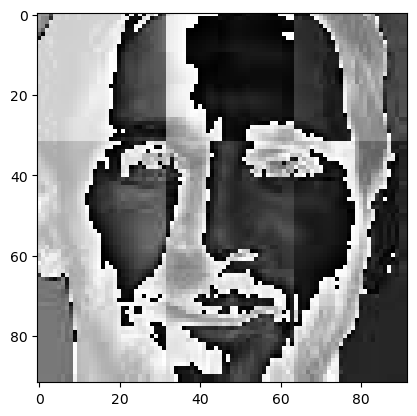

In [64]:
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har, cmap='gray')

In [65]:
class_dict={}
count=0
for player_name in player_file_names_dict.keys():
    class_dict[player_name] = count
    count +=1
class_dict 

{'Cristiano Ronaldo': 0,
 'Kylian Mbappe': 1,
 'Leonel Messi': 2,
 'Neymar Jr': 3,
 'Trent Alexander': 4}

In [66]:
X=[]
y=[]

for player_name, training_files in player_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scaled_raw_image = cv2.resize(img, (32,32))
        img_har = w2d(img, 'db1', 5)
        scaled_img_har = cv2.resize(img_har, (32,32))
        combined_image = np.vstack((scaled_raw_image.reshape(32*32*3,1),scaled_img_har.reshape(32*32,1)))
        X.append(combined_image)
        y.append(class_dict[player_name])


In [67]:
len(X[0])

4096

In [68]:
X = np.array(X).reshape(len(X),4096).astype(float)

In [69]:
X[0]

array([ 13.,  17.,  18., ..., 159.,   2.,   1.])

# Using SVM

In [70]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()),('svc', SVC(kernel='rbf', C=10))])
pipe.fit(X_train,y_train)
pipe.score(X_test,y_test)

0.7204301075268817

In [72]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72        25
           1       0.61      0.70      0.65        20
           2       0.80      0.63      0.71        19
           3       0.85      0.69      0.76        16
           4       0.71      0.92      0.80        13

    accuracy                           0.72        93
   macro avg       0.74      0.73      0.73        93
weighted avg       0.73      0.72      0.72        93



# Using GridSearch

In [73]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [74]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [75]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.758701,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.518117,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.809221,{'logisticregression__C': 1}


In [76]:
best_estimators['svm'].score(X_test,y_test)

0.7849462365591398

In [77]:
best_estimators['random_forest'].score(X_test,y_test)

0.45161290322580644

In [78]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7634408602150538

In [85]:
best_clf = best_estimators['svm']

In [86]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[22,  0,  1,  1,  1],
       [ 2, 17,  0,  0,  1],
       [ 4,  1, 13,  1,  0],
       [ 2,  1,  0, 12,  1],
       [ 2,  2,  0,  0,  9]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

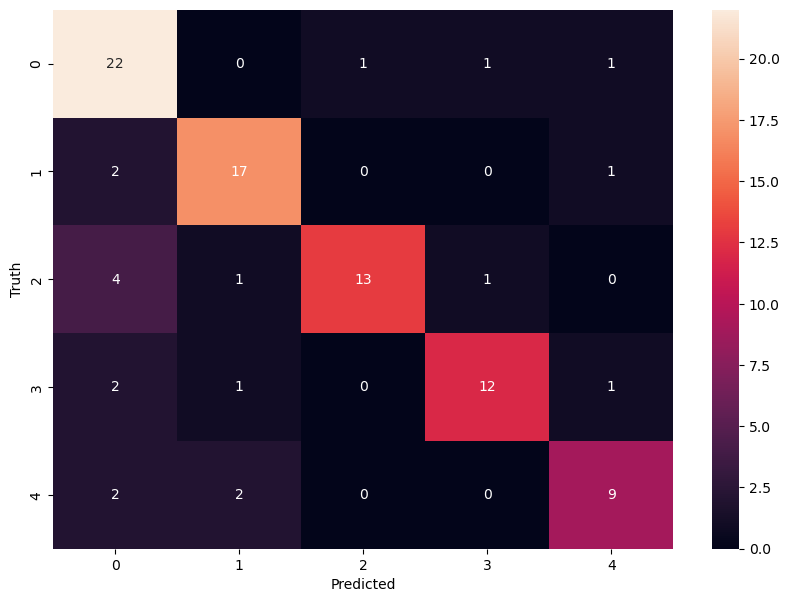

In [87]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [88]:
class_dict

{'Cristiano Ronaldo': 0,
 'Kylian Mbappe': 1,
 'Leonel Messi': 2,
 'Neymar Jr': 3,
 'Trent Alexander': 4}

In [89]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [90]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))